### Imports 

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
import lightgbm as lgb

In [4]:
from scipy.stats import ttest_rel

### Const and Func

In [5]:
np.random.seed(42)

In [6]:
path = Path('data/dataset/')

In [7]:
path

PosixPath('data/dataset')

In [8]:
! ls {path}

 bs_avg_kpi.csv   '!dataset_fields_description.xlsx'   test
 bs_chnn_kpi.csv   sample-submit-zero.csv	       train


In [9]:
! ls {path/'train'}

subs_bs_consumption_train.csv	 subs_csi_train.csv
subs_bs_data_session_train.csv	 subs_features_train.csv
subs_bs_voice_session_train.csv


In [10]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [11]:
def margin_of_error(z, data):
    n, std = len(data), data.std()
    z_critical = scipy.stats.norm.ppf(q=z)
    return z_critical * (std / np.sqrt(n))

### Loads

In [12]:
train_ids = pd.read_csv(path/'train/subs_csi_train.csv', sep=';')

In [13]:
test_ids = pd.read_csv(path/'test/subs_csi_test.csv', sep=';')

In [14]:
features_train = pd.read_csv(path/'train/subs_features_train.csv', sep=';', decimal=',', 
                              parse_dates=['SNAP_DATE'], infer_datetime_format=True, dayfirst=True)

In [15]:
features_test = pd.read_csv(path/'test/subs_features_test.csv', sep=';', decimal=',', 
                              parse_dates=['SNAP_DATE'], infer_datetime_format=True, dayfirst=True)

In [16]:
# convert to months (int)
features_train.SNAP_DATE = features_train.SNAP_DATE.dt.month

In [17]:
# convert to months (int)
features_test.SNAP_DATE = features_test.SNAP_DATE.dt.month

In [18]:
consum_train = pd.read_csv(path/'train/subs_bs_consumption_train.csv', sep=';', decimal=',', 
                           usecols=['SK_ID', 'SUM_MINUTES', 'SUM_DATA_MB','SUM_DATA_MIN'])

In [19]:
consum_test = pd.read_csv(path/'test/subs_bs_consumption_test.csv', sep=';', decimal=',',
                         usecols=['SK_ID', 'SUM_MINUTES', 'SUM_DATA_MB','SUM_DATA_MIN'])

In [20]:
consum_train.head()

,SK_ID,SUM_MINUTES,SUM_DATA_MB,SUM_DATA_MIN
0,1827,0.000000,0.000002,0.000234
1,1827,0.000072,0.000000,0.000000
2,1827,0.000000,0.000019,0.000326
3,1827,0.016576,0.002260,0.004329
4,1827,0.012755,0.001186,0.002491


###  Data processing

In [21]:
train_ids.SK_ID.nunique(), features_train.SK_ID.nunique()

(4222, 4222)

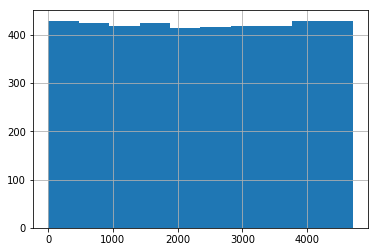

In [18]:
train_ids.SK_ID.hist();

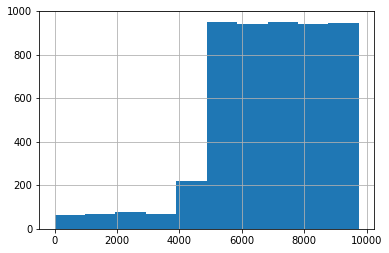

In [19]:
test_ids.SK_ID.hist();

#### Id-based validation

In [18]:
features_test.SNAP_DATE.unique()

array([10,  7,  6,  1,  8,  4,  5, 11,  9,  2, 12,  3])

In [22]:
raw_train = features_train[features_train.SNAP_DATE.isin([6,7,8,9,10,11,12])].copy()
raw_test = features_test[features_test.SNAP_DATE.isin([1,2,3,4,5])].copy()

### Aggregation

In [23]:
for df in (raw_train, raw_test):
    df.drop('SNAP_DATE', axis=1, inplace=True)

In [24]:
for df in (raw_train,raw_test):
    print('====')
    for n, c in df.iteritems():
        if c.nunique() < 10:
            print(n, '-->', c.nunique(), c.dtype)

====
COM_CAT#1 --> 8 int64
BASE_TYPE --> 2 int64
ACT --> 2 int64
COM_CAT#7 --> 9 int64
DEVICE_TYPE_ID --> 8 float64
INTERNET_TYPE_ID --> 3 float64
COM_CAT#24 --> 1 object
COM_CAT#25 --> 1 int64
COM_CAT#26 --> 2 int64
====
COM_CAT#1 --> 8 int64
BASE_TYPE --> 2 int64
ACT --> 2 int64
COM_CAT#7 --> 9 int64
DEVICE_TYPE_ID --> 8 float64
INTERNET_TYPE_ID --> 3 float64
COM_CAT#24 --> 7 object
COM_CAT#25 --> 2 int64
COM_CAT#26 --> 2 int64


In [25]:
train_cats(raw_train)
apply_cats(raw_test, raw_train)

In [26]:
tr_gr = raw_train.groupby('SK_ID', as_index=False).agg(['mean', 'max', 'min'])
test_gr = raw_test.groupby('SK_ID', as_index=False).agg(['mean', 'max', 'min'])

In [27]:
for df in (tr_gr, test_gr):
    df.columns = ['_'.join(c) for c in df.columns]

In [28]:
# add contact date and labels
tr_gr = pd.merge(tr_gr, train_ids, on='SK_ID')

In [29]:
test_gr = pd.merge(test_ids, test_gr, on='SK_ID', how='left')

In [30]:
for df in (tr_gr, test_gr):
    df['CONTACT_DATE'] = pd.to_datetime(df['CONTACT_DATE'], format='%d.%m').dt.day

In [31]:
(tr_gr.shape,test_gr.shape)

((3976, 102), (5221, 101))

####  Aggregation consumption

In [32]:
for df in (consum_train, consum_test):
    print('====')
    for n, c in df.iteritems():
        if c.nunique() < 10:
            print(n, '-->', c.nunique(), c.dtype)

====
====


In [33]:
consum_gr_tr = consum_train.groupby('SK_ID', as_index=False).agg(['mean', 'max', 'min'])
consum_gr_test = consum_test.groupby('SK_ID', as_index=False).agg(['mean', 'max', 'min'])

In [37]:
for df in (consum_gr_tr, consum_gr_test):
    df.columns = ['_'.join(c) for c in df.columns]

#### Merge features and consumptions

In [42]:
# add contact date and labels
tr_gr = pd.merge(tr_gr, consum_gr_tr, on='SK_ID')

In [44]:
test_gr = pd.merge(test_gr, consum_gr_test, on='SK_ID', how='left')

In [45]:
(tr_gr.shape,test_gr.shape)

((3969, 111), (5221, 110))

### Train

In [46]:
tr_gr = tr_gr.sample(frac=1).reset_index(drop=True)

In [47]:
df, y_tr, nas = proc_df(tr_gr.drop(['SK_ID'], axis=1), 'CSI')

In [48]:
test, _, _ = proc_df(test_gr.drop(['SK_ID'], axis=1), na_dict=nas)

In [49]:
test.shape

(5221, 124)

In [50]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=10)
m.fit(df, y_tr)
m.score(df, y_tr)

0.9748047367094986

In [51]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 600
n_trn = len(df)-n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y_tr, n_trn)

In [52]:
X_train.shape, X_valid.shape, y_train.mean(), y_valid.mean()

((3369, 124), (600, 124), 0.16028495102404275, 0.13333333333333333)

In [53]:
def print_score(m):
    res = [metrics.roc_auc_score(y_train, m.predict_proba(X_train)[:,1]), 
           metrics.roc_auc_score(y_valid, m.predict_proba(X_valid)[:,1]),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [58]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=80, min_samples_leaf=50, max_features=0.5, 
                            oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.8857579566133826, 0.5421394230769231, 0.8397150489759573, 0.8666666666666667, 0.8397150489759573]


In [41]:
m = lgb.LGBMClassifier()
m.fit(X_train, y_train)
print_score(m)

[0.9999267361696205, 0.5385721730067743, 0.9834123222748815, 0.84]


### Feature Importance 

In [123]:
fi = rf_feat_importance(m, X_train)

In [124]:
fi[:10]

,cols,imp
36,VAS_mean,0.043165
41,RENT_CHANNEL_min,0.035422
82,COM_CAT#29_max,0.033061
37,VAS_max,0.031856
76,COM_CAT#27_max,0.031613
23,COM_CAT#8_min,0.027917
89,COM_CAT#31_min,0.027424
75,COM_CAT#27_mean,0.026608
66,COM_CAT#23_mean,0.026352
40,RENT_CHANNEL_max,0.025959


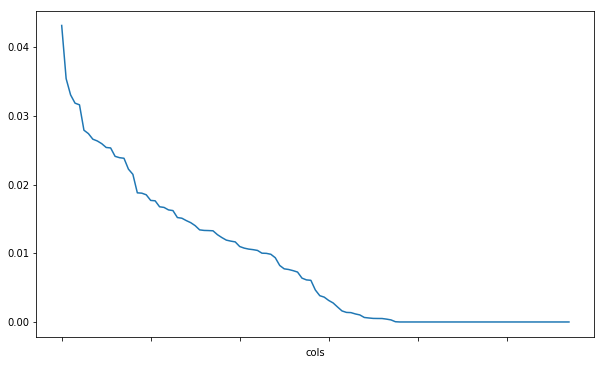

In [125]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [126]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

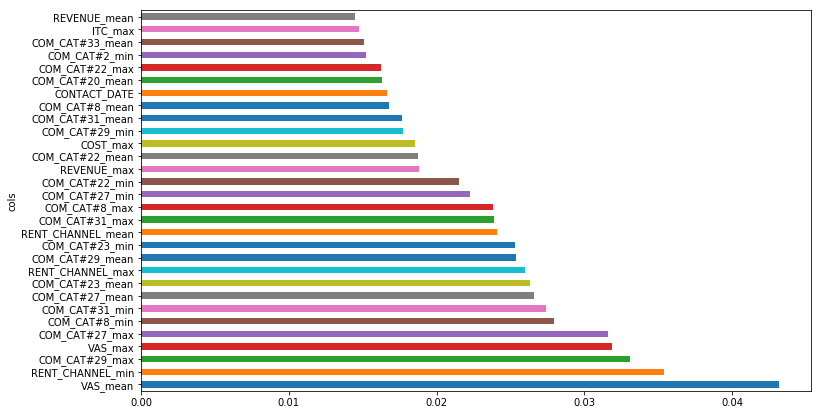

In [127]:
plot_fi(fi[:30]);

In [128]:
fi.describe()

,imp
count,115.000000
mean,0.008696
std,0.010187
min,0.000000
25%,0.000000
50%,0.004660
75%,0.014608
max,0.043165


In [253]:
to_keep = fi[fi.imp>0].cols; len(to_keep)

76

In [254]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [255]:
df_keep.shape

(3976, 76)

#### Hierarchical Clustering 

In [165]:
from scipy.cluster import hierarchy as hc

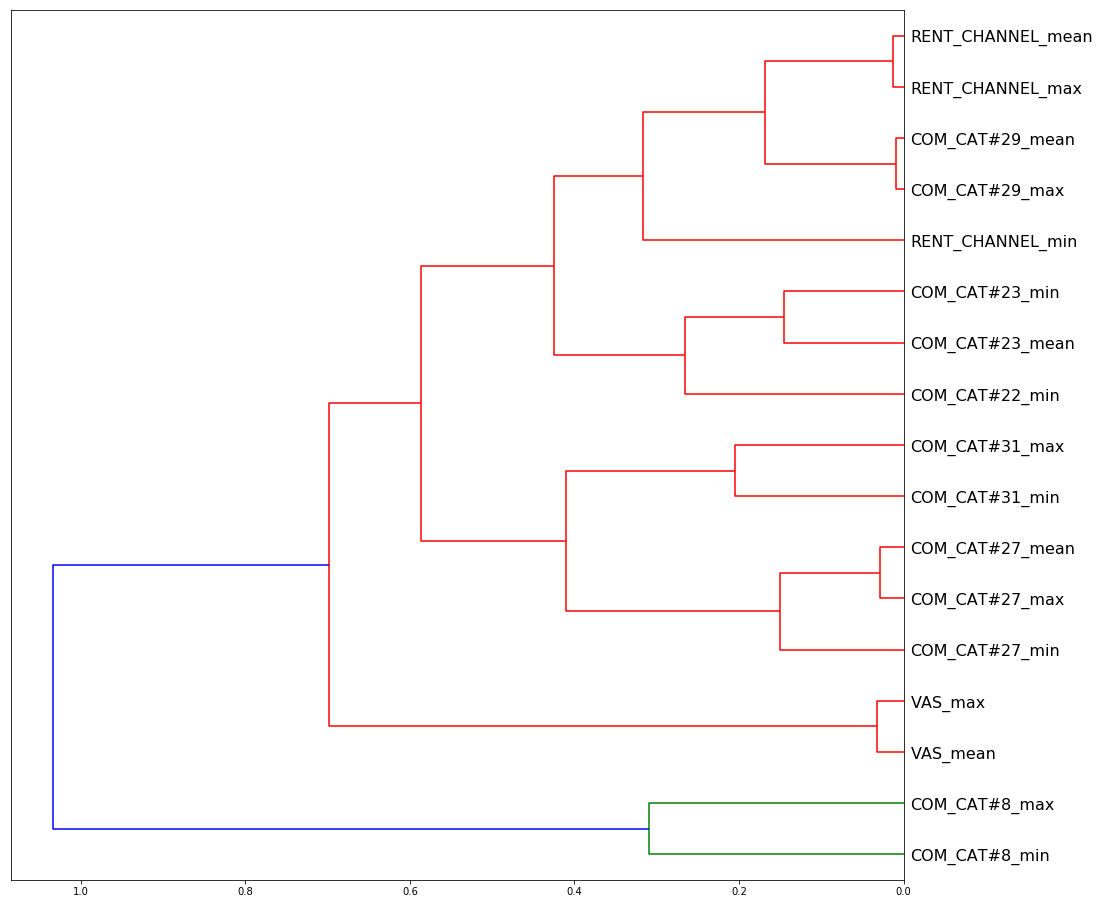

In [166]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,16))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [167]:
def get_oob(df):
    m = RandomForestClassifier(n_estimators=40, random_state=111, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [168]:
get_oob(df_keep)

0.8341232227488151

In [169]:
df_keep.columns

Index(['VAS_mean', 'RENT_CHANNEL_min', 'COM_CAT#29_max', 'VAS_max',
       'COM_CAT#27_max', 'COM_CAT#8_min', 'COM_CAT#31_min', 'COM_CAT#27_mean',
       'COM_CAT#23_mean', 'RENT_CHANNEL_max', 'COM_CAT#29_mean',
       'COM_CAT#23_min', 'RENT_CHANNEL_mean', 'COM_CAT#31_max',
       'COM_CAT#8_max', 'COM_CAT#27_min', 'COM_CAT#22_min'],
      dtype='object')

In [170]:
for c in ( 'VAS_mean', 'VAS_max', 'COM_CAT#27_max', 'COM_CAT#27_mean', 
          'RENT_CHANNEL_max', 'RENT_CHANNEL_mean', 'COM_CAT#29_max', 'COM_CAT#29_mean'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

VAS_mean 0.8332345971563981
VAS_max 0.8376777251184834
COM_CAT#27_max 0.8356042654028436
COM_CAT#27_mean 0.8359004739336493
RENT_CHANNEL_max 0.8347156398104265
RENT_CHANNEL_mean 0.8367890995260664
COM_CAT#29_max 0.8373815165876777
COM_CAT#29_mean 0.8364928909952607


In [171]:
to_drop =['RENT_CHANNEL_mean', 'COM_CAT#29_max', 'COM_CAT#27_mean', 'VAS_max']
get_oob(df_keep.drop(to_drop, axis=1))

0.8356042654028436

In [172]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [173]:
os.makedirs('data/tmp', exist_ok=True)

In [174]:
np.save('data/tmp/keep_cols.npy', np.array(df_keep.columns))

In [175]:
keep_cols = np.load('data/tmp/keep_cols.npy')

In [92]:
# keep_cols = ['COM_CAT#2_mean', 'COM_CAT#31_max', 'COM_CAT#23_mean', 'COM_CAT#27_max',
#            'REVENUE_min', 'COST_mean', 'VAS_max', 'COM_CAT#27_min',
#            'RENT_CHANNEL_min', 'COM_CAT#8_max']

In [176]:
len(keep_cols)

13

In [177]:
df_keep = df_keep[keep_cols]
X_train, X_valid = split_vals(df_keep, n_trn)

#### Univariate plots on test - valid 

In [178]:
from featexp import get_univariate_plots

In [179]:
get_univariate_plots(data=raw_tr, target_col='CSI', features_list=to_keep, data_test=raw_te)

NameError: name 'raw_tr' is not defined

In [135]:
from featexp import get_trend_stats

In [136]:
get_trend_stats(data=raw_tr, target_col='CSI', features_list=to_keep, data_test=raw_te)

Returning stats for all numeric features


,Feature,Trend_changes,Trend_changes_test,Trend_correlation
0,RENT_CHANNEL_min,6,4,0.804366
1,VAS_max,5,7,0.341697
2,COM_CAT#31_max,4,5,0.413230
3,COST_mean,7,6,0.031269
4,COM_CAT#27_max,4,4,0.499216


In [186]:
m = lgb.LGBMClassifier()
m.fit(X_train, y_train)
print_score(m)

[0.9999757084421613, 0.5010187810063784, 0.968266456858117, 0.83]


In [188]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=10, 
                            oob_score=True)
m.fit(X_train, y_train)
print_score(m)

/Users/alexeydemyanchuk/.virtualenvs/kaggle_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexeydemyanchuk/.virtualenvs/kaggle_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[0.999681569361375, 0.4646748759744862, 0.975609756097561, 0.8275, 0.8075006556517178]



#### T statistics 

In [256]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=80, max_features=1, min_samples_leaf=30)
m.fit(X_train, y_train)
print_score(m)

[0.834492634482027, 0.578376412187607, 0.8430094786729858, 0.8466666666666667]


In [201]:
m = lgb.LGBMClassifier()
m.fit(X_train, y_train)
print_score(m)

[0.9995440929157031, 0.5482761741018912, 0.9597156398104265, 0.8516666666666667]


In [257]:
m_A = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_features=0.5, min_samples_leaf=50)

In [258]:
m_B = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_features=0.5, min_samples_leaf=50)

In [259]:
scoring =  metrics.make_scorer(metrics.roc_auc_score, needs_proba=True)

scores_A = np.array([])
scores_B = np.array([])

In [260]:
for i in range(10):
    fold = sklearn.model_selection.KFold(
        n_splits=5, shuffle=True, random_state=i)

    current_scores_A = sklearn.model_selection.cross_val_score(
        estimator=m_A, X=df, y=y_tr, cv=fold, scoring=scoring, n_jobs=-1)

    scores_A = np.append(scores_A, current_scores_A)

    current_scores_B = sklearn.model_selection.cross_val_score(
        estimator=m_B, X=df_keep, y=y_tr, cv=fold, scoring=scoring, n_jobs=-1)

    scores_B = np.append(scores_B, current_scores_B)
    
ttest_rel(scores_A, scores_B)

Ttest_relResult(statistic=0.5430984574183724, pvalue=0.5895241766486081)

In [261]:
scores_A.mean(), margin_of_error(0.975, scores_A)

(0.5623971355773206, 0.006790673322751574)

In [262]:
scores_B.mean(), margin_of_error(0.975, scores_B)

(0.5611873650121167, 0.006642397507051546)

 - last 5 months vs full data `Ttest_relResult(statistic=-0.5739371988382607, pvalue=0.5686356084768682)`
 - last 5 months vs last 8 months `Ttest_relResult(statistic=0.6013845705864069, pvalue=0.5503561387167131)`
 - last 5 months vs last 3 months `Ttest_relResult(statistic=0.7411994751002573, pvalue=0.46211007794300796)`
 - last 5 months vs last 1 month `Ttest_relResult(statistic=0.23439294381926984, pvalue=0.8156565977942658)`
 - **last 5 months vs first 7 months** `Ttest_relResult(statistic=-4.606351117888431, pvalue=2.940069851986962e-05)`
 - last 5 months vs Nov-Mar `Ttest_relResult(statistic=0.538136115643363, pvalue=0.5929192015989826)`
 - last 5 months vs first 10 months `Ttest_relResult(statistic=-0.5254235366522199, pvalue=0.6016584866362571)`
 - **last 5 months vs Jan-Mar** `Ttest_relResult(statistic=4.410632452196336, pvalue=5.6370093653997715e-05)`
 - **last 5 months vs last 2 months** `Ttest_relResult(statistic=1.9717617159255272, pvalue=0.05429614296591497)`

In [202]:
df_keep.shape, y.shape

((3976, 11), (3976,))

In [203]:
# in case you allready have scores_A
m_B = lgb.LGBMClassifier()
scoring =  metrics.make_scorer(metrics.roc_auc_score, needs_proba=True)
scores_B = np.array([])

for i in range(10):
    fold = sklearn.model_selection.KFold(
        n_splits=5, shuffle=True, random_state=i)

    current_scores_B = sklearn.model_selection.cross_val_score(
        estimator=m_B, X=df_keep, y=y, cv=fold, scoring=scoring, n_jobs=-1)

    scores_B = np.append(scores_B, current_scores_B)
    
ttest_rel(scores_A, scores_B)

Ttest_relResult(statistic=-1.7363571239660691, pvalue=0.08878494564496622)

In [204]:
scores_A.mean(), margin_of_error(0.975, scores_A)

(0.53988555034028, 0.005483348192116968)

In [205]:
scores_B.mean(), margin_of_error(0.975, scores_B)

(0.5458719949508225, 0.006588983839327142)

#### Cross-val predict

In [252]:
m = lgb.LGBMClassifier()

In [41]:
scoring =  {'roc_auc': metrics.make_scorer(metrics.roc_auc_score, needs_proba=True)}

In [254]:
scores = sklearn.model_selection.cross_validate(
    m, df_keep, y, cv=5, scoring=scoring,
    return_train_score=True, return_estimator=True)

In [255]:
scores['train_roc_auc'].mean(), margin_of_error(0.975, scores['train_roc_auc'])

(0.9999970014694396, 2.662000226861619e-06)

In [256]:
scores['test_roc_auc'].mean(), margin_of_error(0.975, scores['test_roc_auc'])

(0.5208320020492699, 0.014217074471451045)

In [216]:
pred_y = np.zeros(len(test))
for est in scores['estimator']:
    pred_y += est.predict_proba(test[to_keep])[:,1] / 5

In [75]:
df.shape, valid.shape, test.shape

((3976, 115), (4213, 115), (5221, 115))

In [77]:
scoring =  {'roc_auc': metrics.make_scorer(metrics.roc_auc_score, needs_proba=True)}
scores_ovaerall_tr = np.array([])
scores_ovaerall_val = np.array([])

pred_y = np.zeros((len(test), 10))

for i in range(10):
    m = RandomForestClassifier(n_jobs=-1, n_estimators=80, max_features=.7, min_samples_leaf=50)
    
    fold = sklearn.model_selection.KFold(
        n_splits=5, shuffle=True, random_state=i)
    
    scores = sklearn.model_selection.cross_validate(
        m, df, y_tr, cv=fold, scoring=scoring,
        return_train_score=True, return_estimator=True, n_jobs=-1)
    
    scores_ovaerall_tr = np.append(scores_ovaerall_tr, scores['train_roc_auc'])
    scores_ovaerall_val = np.append(scores_ovaerall_val, scores['test_roc_auc'])
    
    for est in scores['estimator']:
        pred_y[:,i] += est.predict_proba(test)[:,1] / 5

In [78]:
scores_ovaerall_tr.mean(), margin_of_error(0.975, scores_ovaerall_tr)

(0.8821534895718119, 0.002535367137490656)

In [79]:
scores_ovaerall_val.mean(), margin_of_error(0.975, scores_ovaerall_val)

(0.5609850490833667, 0.006464896720100968)

In [80]:
pred_y = pred_y.mean(axis=1)

### Predict on test and submit

In [58]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=100, min_samples_leaf=12, max_features=0.8, 
                           random_state=111)
m.fit(df, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=12, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=111, verbose=0, warm_start=False)

In [173]:
m = lgb.LGBMClassifier()
m.fit(df, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [59]:
pred_y = m.predict_proba(test)[:,1]

In [82]:
subm = pd.DataFrame(pred_y)

In [83]:
subm.shape

(5221, 1)

In [84]:
subm.to_csv('submits/rf_cv_first7_train_last5_test_consum_all.csv', index=False, header=False)

### Local Validation vs LB

- 'lgb_t-test_val_full_last5 months' local predict, ci: (0.5216179343069107, 0.006672037004185105); LB:0.51221
- 'lgb_t-test_val_full_first7'     local predict, ci: (0.5384367387214946, 0.005560330542734631); LB:0.53891
- 'lgb_t-test_val_full_first7+id'    local predict, ci: (0.5385112223124687, 0.0055238218737344); LB:0.53546
- *'lgb_t-test_val_full_first7+id+fi' local predict, ci: (0.5474994543180034, 0.005521392094374423); LB:0.51444*
- 'lgb_t-test_val_full_first7_fi'    local predict, ci: (0.5459079501018401, 0.005487685723475682); LB:0.52712

 - lgb_cv_full_first7 local predict, ci: (0.52633, 0.01120); LB:0.53010
 - **lgb_cv_full_first7_fi63 'not zero fi' local predict, ci: (0.54592, 0.00548); LB:0.52488**
 - lgb_cv_full_first7_fi_dendr local predict, ci: (0.53335, 0.00600); LB:0.52541
 - **lgb_cv_full_first7_fi_13_keep_cols local predict, ci: (0.54323, 0.00722); LB:0.51444**
 - **lgb_cv_full_first7_fi_11_keep_cols local predict, ci: (0.54587, 0.00658); LB:0.50950**

 - rf_underfit_cv_first7_fi_not_0 local predict, ci: (0.55890, 0.00582); LB:0.52541
 - rf_underfit1_cv_first7_fi_not_0 local predict, ci: (0.55064, 0.00608); LB:0.51319
 - rf_underfit2_cv_first7_fi_11_keep_cols local predict, ci: (0.55757, 0.00547); LB:0.51943

- **rf_cv_first7_train_last5_test_all local predict, ci: (0.56462, 0.00687), valid_future: 0.61854, LB: 0.55264**
- rf_cv_first7_train_last5_test_keep_cols13 local predict, ci: (0.56247, 0.00639), valid_future: 0.57869, LB: 0.53213
- rf_cv_first7_train_last5_test_consum_all local predict, ci: (0.56098, 0.00646), LB: 0.55550